# Importing Libraries

In [195]:
import random
import math
from collections import Counter
import matplotlib.pyplot as plt
import heapq
import copy

# Initializing Variables

In [196]:
NUM_STUDENTS = 1000                           # Total number of students
NUM_GROUPS = 5                                # Total number of groups
POPULARITY = [0] * NUM_STUDENTS               # Popularity (0-1) indexed (0-1000)
CLASS_GROUPS = [0] * NUM_STUDENTS             # Class groups indexed (0-1000)
SPORT_GROUPS = [0] * NUM_STUDENTS             # Sport groups indexed (0-1000)
AREA_GROUPS = [0] * NUM_STUDENTS              # Area groups indexed (0-1000)
NETWORK = [[] for _ in range(NUM_STUDENTS)]   # Network as an adjacency list indexed (0-1000)
EDGE_WEIGHT_CUTOFF = 2.25                     # Cutoff for considering 2 nodes as friends

In [197]:
raw_popularity = [random.expovariate(1.5) for _ in range(NUM_STUDENTS)]   # Random popularity values skewed towards 0
POPULARITY = [x / max(raw_popularity) for x in raw_popularity]            # Normalize popularity values
CLASS_GROUPS = [random.randint(1, 5) for _ in range(NUM_STUDENTS)]        # Random distribution of the 5 class groups
SPORT_GROUPS = [random.randint(1, 5) for _ in range(NUM_STUDENTS)]        # Random distribution of the 5 sport groups
AREA_GROUPS = [random.randint(1, 5) for _ in range(NUM_STUDENTS)]         # Random distribution of the 5 area groups

print(POPULARITY)
print(Counter(CLASS_GROUPS))
print(Counter(SPORT_GROUPS))
print(Counter(AREA_GROUPS))

[0.023599143781233956, 0.08014368939797574, 0.20048901096920174, 0.016605106691456525, 0.03925755911873342, 0.1307383549212398, 0.22462576682934346, 0.2333551531881851, 0.1382246391144468, 0.018888604960675615, 0.1338936368780881, 0.008690903148808635, 0.20742285251663464, 0.01332166730638519, 0.2002408757282928, 0.10012564482473543, 0.17507123750929582, 0.012381962961383252, 0.007196115779468328, 0.11416827712091464, 0.038851331151558095, 0.09167903263770731, 0.10460923819252443, 0.3036012622756041, 0.021927524927730098, 0.00888063741542709, 0.20095164441849286, 0.15415185401539067, 0.04933933009273717, 0.4363657957619757, 0.26514633300486234, 0.09140812809014638, 0.07710503771312399, 0.14974428340553558, 0.13120455469681314, 0.07192888272148032, 0.3685779784314958, 0.07741066362975126, 0.195708055093488, 0.19026938825106884, 0.06873212845865023, 0.03535950753106605, 0.6018391337102705, 0.138435374635425, 0.12685169633232224, 0.4180016536296686, 0.06505624829240007, 0.0781072308660820

# Part 1

Creating Edges

In [198]:
def edge_weight(i, j):
    similarity = 0
    if CLASS_GROUPS[i] == CLASS_GROUPS[j]:
        similarity += 0.4
    if SPORT_GROUPS[i] == SPORT_GROUPS[j]:
        similarity += 0.25
    if AREA_GROUPS[i] == AREA_GROUPS[j]:
        similarity += 0.2
    pop_factor = (2 * POPULARITY[i] * POPULARITY[j]) / (POPULARITY[i] + POPULARITY[j])
    base_score = similarity * (0.7 + 0.3 * pop_factor)
    random_factor = 0.15 * (random.random() ** 0.5)
    probability = 1 / (1 + math.exp(-(base_score + random_factor - 0.5)))
    if probability > 0.5:
        weight = probability * (0.9 + 0.1*random.random())
        return (True, weight)
    return (False, 0)

for i in range(NUM_STUDENTS):
    for j in range(i+1, NUM_STUDENTS):
        should_connect, weight = edge_weight(i, j)
        if should_connect:
            NETWORK[i].append((j, weight))
            NETWORK[j].append((i, weight))

for i in range(NUM_STUDENTS):
    for j in range(i+1, NUM_STUDENTS):
        if not any(friend == j for (friend, _) in NETWORK[i]):
            mutual = len(set(friend for (friend, w) in NETWORK[i]).intersection(set(friend for (friend, w) in NETWORK[j])))
            if mutual > 0:
                bridge_prob = 1 - math.exp(-mutual)
                if random.random() < bridge_prob:
                    _, weight = edge_weight(i, j)
                    weight *= 0.75
                    NETWORK[i].append((j, weight))
                    NETWORK[j].append((i, weight))

Normalizing Edge Weight (1-10)

In [199]:
max_weight = max(max(weight for (_, weight) in neighbors) for neighbors in NETWORK)
NETWORK = [[(j, weight / max_weight) for (j, weight) in neighbors] for neighbors in NETWORK]                                   # Normalizing all weights

min_weight = min(min(weight for (_, weight) in neighbours) for neighbours in NETWORK)
NETWORK = [[(j, (10 - min_weight - 9 * weight) / (1 - min_weight)) for (j, weight) in neighbours] for neighbours in NETWORK]   # Mapping (min_weight-1)->(1-10)

Plot of Number of Friends vs Number of Students

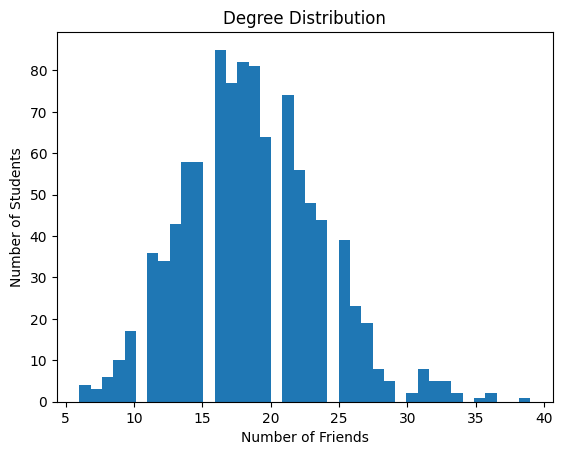

In [200]:
degrees = [sum(1 for (_, w) in neighbors if w < EDGE_WEIGHT_CUTOFF) for neighbors in NETWORK]   # Counting only those edges with weight < cutoff

plt.hist(degrees, bins=max(degrees) + 1)
plt.xlabel("Number of Friends")
plt.ylabel("Number of Students")
plt.title("Degree Distribution")
plt.show()

# Part 2

Counting Connected Components

In [201]:
def dfs(node, cutoff, visited, NETWORK):
  size = 0
  stack = [node]
  while stack:
    u = stack.pop()
    if u not in visited:
      visited.add(u)
      size += 1
      for neighbor, weight in NETWORK[u]:
        if weight < cutoff and neighbor not in visited:
          stack.append(neighbor)
  return size

visited = set()
sizes = []
for node in range(NUM_STUDENTS):
  if node not in visited:
    size = dfs(node, EDGE_WEIGHT_CUTOFF, visited, NETWORK)
    sizes.append(size)

print(f'Number of connected components: {len(sizes)}')
print(f'Maximum size of a connected component: {max(sizes)}')
print(f'Minimum size of a connected component: {min(sizes)}')

Number of connected components: 4
Maximum size of a connected component: 410
Minimum size of a connected component: 185


# Part 3

Dijkstra's Algorithm

In [202]:
def dijkstra(start, end, NETWORK):
  distances = [float('inf')] * NUM_STUDENTS
  previous = [None] * NUM_STUDENTS
  distances[start] = 0
  pq = [(0, start)]

  while pq:
    dist, u = heapq.heappop(pq)
    if u == end:
      break
    if dist > distances[u]:
      continue
    for v, weight in NETWORK[u]:
      total_dist = dist + weight
      if total_dist < distances[v]:
        distances[v] = total_dist
        previous[v] = u
        heapq.heappush(pq, (total_dist, v))

  path = []
  curr = end
  while curr is not None:
    path.append(curr)
    curr = previous[curr]
  path.reverse()

  if distances[end] == float('inf'):
    return -1, []
  else:
    return distances[end], path

A* Algorithm

In [203]:
def heuristic(u, v, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS, x=4, y=2.5, z=2):
    same_class = int(CLASS_GROUPS[u] == CLASS_GROUPS[v])
    same_sport = int(SPORT_GROUPS[u] == SPORT_GROUPS[v])
    same_area = int(AREA_GROUPS[u] == AREA_GROUPS[v])
    return 10 - (x * same_class + y * same_sport + z * same_area)

def a_star(start, end, NETWORK, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS):
    num_nodes = len(NETWORK)
    open_set = [(0, start)]
    came_from = {}
    g_score = [float('inf')] * num_nodes
    g_score[start] = 0

    f_score = [float('inf')] * num_nodes
    f_score[start] = heuristic(start, end, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS)

    visited = set()

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return g_score[end], path

        visited.add(current)

        for neighbor, weight in NETWORK[current]:
            if neighbor in visited:
                continue
            tentative_g = g_score[current] + weight
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic(neighbor, end, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return -1, []

5 Random Pairs

In [204]:
STUDENT_PAIRS = [tuple(random.sample(range(1000), 2)) for _ in range(5)]

print("Dijkstra:")
for start, end in STUDENT_PAIRS[:-1]:
  distance, path = dijkstra(start, end, NETWORK)
  print(f"Distance between {start} and {end}: {distance:.2f}, Path: {path}")

print()
start, end = STUDENT_PAIRS[-1]
distance, path = a_star(start, end, NETWORK, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS)
print(f"Distance between {start} and {end} (A*): {distance:.2f}, Path: {path}")
distance, path = dijkstra(start, end, NETWORK)
print(f"Distance between {start} and {end} (Dijkstra): {distance:.2f}, Path: {path}")
distance = heuristic(start, end, CLASS_GROUPS, SPORT_GROUPS, AREA_GROUPS)
print(f"Distance between {start} and {end} (Heuristic): {distance:.2f}")

Dijkstra:
Distance between 659 and 213: 4.36, Path: [659, 671, 213]
Distance between 22 and 596: 6.73, Path: [22, 302, 891, 596]
Distance between 58 and 78: 7.00, Path: [58, 293, 820, 78]
Distance between 342 and 935: 6.86, Path: [342, 255, 743, 935]

Distance between 241 and 796 (A*): 10.00, Path: [241, 796]
Distance between 241 and 796 (Dijkstra): 8.96, Path: [241, 741, 595, 837, 796]
Distance between 241 and 796 (Heuristic): 10.00


# Bonus

Finding Bridge Nodes

In [205]:
def bridge_nodes(NETWORK, cutoff):
    n = len(NETWORK)
    visited = [False] * n
    tin = [-1] * n
    low = [-1] * n
    timer = [0]
    bridge_nodes = set()

    def dfs(u, parent):
        visited[u] = True
        tin[u] = low[u] = timer[0]
        timer[0] += 1
        children = 0

        for v, w in NETWORK[u]:
            if w > cutoff or v == parent:
                continue
            if visited[v]:
                low[u] = min(low[u], tin[v])
            else:
                dfs(v, u)
                low[u] = min(low[u], low[v])
                if low[v] >= tin[u] and parent != -1:
                    bridge_nodes.add(u)
                children += 1

        if parent == -1 and children > 1:
            bridge_nodes.add(u)

    for i in range(n):
        if not visited[i]:
            dfs(i, -1)

    return bridge_nodes

bridge_nodes = bridge_nodes(NETWORK, EDGE_WEIGHT_CUTOFF)
print("Bridge Nodes:", sorted(bridge_nodes))

Bridge Nodes: [473, 719]


Removing Bridge Nodes

In [206]:
NETWORK2 = copy.deepcopy(NETWORK)

for node in bridge_nodes:
    NETWORK2[node] = []
    for neighbours in NETWORK2:
        neighbours[:] = [(v, w) for v, w in neighbours if v != node]

visited = set()
sizes = []

for node in range(NUM_STUDENTS):
  if node not in visited:
    size = dfs(node, 2.24, visited, NETWORK2)
    sizes.append(size)

print(f'Number of connected components: {len(sizes)}')
print(f'Maximum size of a connected component: {max(sizes)}')
print(f'Minimum size of a connected component: {min(sizes)}')

Number of connected components: 7
Maximum size of a connected component: 212
Minimum size of a connected component: 1
